In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.stats import norm
from sklearn.datasets import load_digits

# Generative Model - Using Kernel Density Estimation

What is KDE? . . .

Why use KDE? . . .
 - Problem with using histogram as density estimator is that the choice of bin size and locations can lead to incaccurate estimations

In [ ]:
cover = pd.read_csv('/Users/gabestechschulte/Downloads/covertype.csv')
cover.drop('Unnamed: 0', axis=1, inplace=True)
cover.head()

In [3]:
X = np.array(cover.iloc[:, 0:2])
y = np.array(cover.iloc[:, -1])

In [96]:
#X = np.array(cover.iloc[0:1000, 0:2])
#y = np.array(cover.iloc[0:1000, -1])

In [178]:
print(X.shape)
print(y.shape)

(581012, 2)
(581012,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

<AxesSubplot:ylabel='Density'>

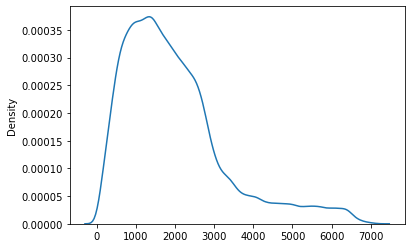

In [8]:
#sns.kdeplot(X_train[:, 0]) ## Elevation
#sns.kdeplot(X_train[:, 1]) ## Horizontal Distance to Fire Points

In [ ]:
kde = KernelDensity(bandwidth=10, kernel='gaussian').fit(X_train)
logprobs = kde.score_samples(X_train)
probs = np.exp(logprobs)
len(probs)

In [109]:
probs.max() ## Still not exactly at the ~0.0026, but we don't want to overfit

0.001756863530002761

In [ ]:
bandwidths = 10 ** np.linspace(0.0, 1, 100)
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'),
                   {'bandwidth': bandwidths})

grid.fit(X[:, None])

In [49]:
grid.best_params_

{'bandwidth': 10.0}

## Generative Model

$P(Y = y | X)$ $\propto$ $P(X | Y)*P(Y)$

In [110]:
class KDEClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
    
    def fit(self, X, y):
        # Unique classes in the training data
        self.classes_ = np.sort(np.unique(y))
        #print(self.classes_)
        # Identify observations in training set for unique classes - 5 classes means 5 training sets
        # This is used in the next steps for the likelihood function
        training_sets = [X[y == yi] for yi in self.classes_]
        #print(training_sets)
        # Fit a KDE for each unique class observation in training sets: P(X | Y) aka likelihood function
        self.models_ = [KernelDensity(bandwidth = self.bandwidth,
                                     kernel = self.kernel).fit(Xi)
                       for Xi in training_sets]
        # Prior belief based on the number of samples: P(Y) aka prior
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                          for Xi in training_sets]
        # Probs density of observing the class
        #print(np.exp(self.logpriors_))
        
        return self
    
    def predict_probability(self, X):
        # Score samples returns the log of the probability density function (pdf)
        # For each model, return the score on the feature vector in a transposed array
        logprobs = np.array([model.score_samples(X)
                            for model in self.models_]).T
        # Exponentiate since it was returned in log form
        results = np.exp(logprobs + self.logpriors_)
        
        return results / results.sum(1, keepdims = True)
    
    def predict(self, X):
        # Return the class that has the highest probability given the observed feature(s)
        return self.classes_[np.argmax(self.predict_probability(X), 1)]

In [163]:
classes = np.sort(np.unique(y))
training_sets = [X[y == yi] for yi in classes]
models = [KernelDensity(bandwidth = 1, kernel = 'gaussian').fit(Xi) for Xi in training_sets]
logpriors = [np.log(Xi.shape[0] / X.shape[0]) for Xi in training_sets]
logprobs = np.array([model.score_samples(X) for model in models]).T
results = np.exp(logprobs + logpriors)

$P(X | Y = y)$

When $Y = y$, how does the distribution of $X$ change? 
 - Therefore, we are looking at the change in the features distribution conditioning on the class 

In [154]:
len(training_sets) ## 3 unique values, so 3 training sets 

3

In [156]:
models ## 3 training sets, so 3 models

[KernelDensity(bandwidth=1),
 KernelDensity(bandwidth=1),
 KernelDensity(bandwidth=1)]

$P(Y)$ = Prior belief about our unique classes 

In [158]:
np.exp(logpriors) ## probability of observing each respective class given the inputed training sets

array([0.226, 0.585, 0.189])

In [162]:
np.exp(logprobs).shape ## log of the probability density function for features using the 3 training sets

(1000, 3)

In [164]:
classes[np.argmax(results / results.sum(1, keepdims=True))]

5

In [ ]:
bandwidths = 10 ** np.linspace(0, 1.5, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': [1]})
grid.fit(X, y)

In [150]:
print(grid.best_params_)
print(grid.best_score_)

{'bandwidth': 1}
0.413
